# Курсовая работа

### Задание для курсового проекта

Участие в соревновании на Kaggle: https://www.kaggle.com/competitions/real-estate-price-prediction-moscow

Задача в соревновании - предсказать цены на квартиры в датасете test.csv. Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Описание датасета

* __Id__ - идентификационный номер квартиры
* __DistrictId__ - идентификационный номер района
* __Rooms__ - количество комнат
* __Square__ - площадь
* __LifeSquare__ - жилая площадь
* __KitchenSquare__ - площадь кухни
* __Floor__ - этаж
* __HouseFloor__ - количество этажей в доме
* __HouseYear__ - год постройки дома
* __Ecology_1, Ecology_2, Ecology_3__ - экологические показатели местности
* __Social_1, Social_2, Social_3__ - социальные показатели местности
* __Healthcare_1, Helthcare_2__ - показатели местности, связанные с охраной здоровья
* __Shops_1, Shops_2__ - показатели, связанные с наличием магазинов, торговых центров
* __Price__ - цена квартиры

### Сдача проекта

Сдать проект нужно в течение 7 дней после окончания последнего вебинара.

Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.

Необходимо получить __R2 > 0.6__ на Private Leaderboard.

Укажите свой ник на kaggle

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Рекомендации для файла с кодом (ipynb)

Файл должен содержать заголовки и комментарии.

Повторяющиеся операции лучше оформлять в виде функций.

По возможности добавлять графики, описывающие данные (около 3-5).

Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта.

Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний).

Весь проект должен быть в одном скрипте (файл ipynb).

При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.

Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

## 1. EDA. Разведочный анализ данных

### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Функция, отрисовывает "огурчик" из предсказанных значений и реальных
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    # Посчитаем метрики r2_score для тренировочных и тестовых данных 
    r2_train = round(r2(train_true_values, train_pred_values), 3)
    r2_test = round(r2(test_true_values, test_pred_values), 3)
    
    # Выведем их
    print("Train R2:\t" + str(r2_train))
    print("Test R2:\t" + str(r2_test))
    
    plt.figure(figsize=(18,10))
    
    # Первый график - посмотрим, насколько точно прошло предсказание на тренировочных данных
    # Чем более плоский "огурчик", тем точнее.
    # По оси х - предсказанные моделью значения, по оси у - истинные значения из датасета
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    # Второй график - предсказание на валидационных данных
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

In [4]:
# Путь к файлам с данными - в той же папке, что и выполняемый файл
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [5]:
# Загрузим тренировочные и тестовые данные в датасеты
train_df = pd.read_csv(TRAIN_DATASET_PATH) # Данные для обучения модели
test_df = pd.read_csv(TEST_DATASET_PATH) # Данные, для которых нужно предсказать целевую переменную

In [6]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
# Посмотрим типы данных
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
train_df.shape

(10000, 20)

**Выводы по датасету train:**

* Содержит 10000 строк, 19 признаков и 1 целевую переменную.
* признаки Ecology_2, Ecology_3, Shops_2 - категориальные, остальные - числовые. 
* признаки LifeSquare и Healthcare_1 содержат пропущенные значения, необходимо их заполнить.

In [10]:
# аналогично посмотрим данные в тестовом датасете
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [11]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [12]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [13]:
test_df.shape

(5000, 19)

#### Выводы по датасету test:

* Содержит 5000 строк и 19 признаков. 
* Признаки Ecology_2, Ecology_3, Shops_2 - категориальные, остальные - числовые. 
* Признаки LifeSquare и Healthcare_1 также содержат пропущенные значения, необходимо их заполнить.

#### Целевая переменная Price

In [14]:
# Создадим функцию для отрисовки гистограммы распределения значений в признаке column_name
def hist_value_counts(df, column_name, bins_count):
    plt.figure(figsize = (10, 6), dpi=80)
   
    df[column_name].hist(bins=bins_count)
    plt.ylabel('Count')
    plt.xlabel(column_name)

    plt.title('Распределение значений переменной ' + column_name)
    plt.show()

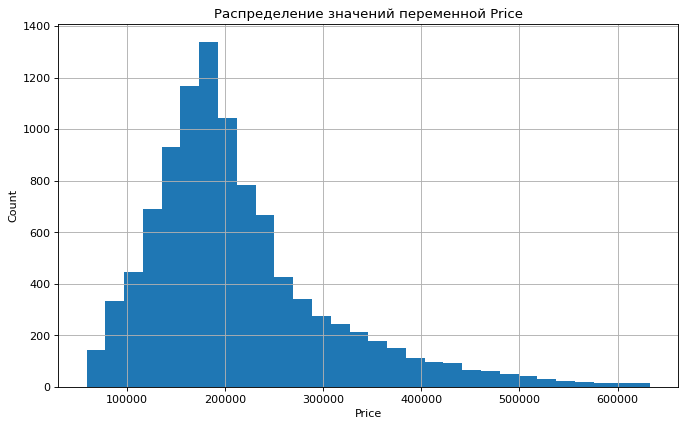

In [15]:
# посмотрим распределение целевой переменной
hist_value_counts(train_df,'Price', 30)

По графику видно, что основная часть значений приходится примерно на промежуток 120 000 - 250 000.

### Категориальные переменные

In [17]:
# Выберем все признаки типа object, далее рассмотрим их более детально
category_columns = train_df.select_dtypes(include='object').columns.tolist()
category_columns

['Ecology_2', 'Ecology_3', 'Shops_2']

#### Id - идентификационый номер квартиры

In [18]:
train_df['Id'].value_counts()

11809    1
2906     1
5039     1
6213     1
12319    1
        ..
2351     1
13054    1
1512     1
11813    1
7202     1
Name: Id, Length: 10000, dtype: int64

Все Id уникальны, т.е. ошибок нет. Вообще, это поле можно использовать как индекс.

#### DistrictId - номер района

In [19]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [20]:
train_df['DistrictId'].describe()

count    10000.000000
mean        50.400800
std         43.587592
min          0.000000
25%         20.000000
50%         36.000000
75%         75.000000
max        209.000000
Name: DistrictId, dtype: float64

Всего в датасете указано 205 районов. 

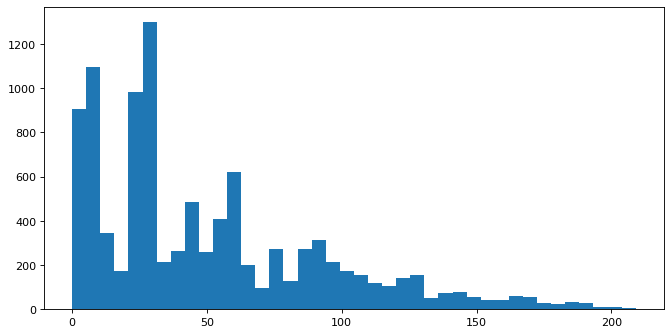

In [21]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['DistrictId'], bins = 40)
plt.show()

In [22]:
train_df['DistrictId'].quantile(0.99)

178.0

#### Ecology_2 - показатели экологии

In [23]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [24]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

Преобладает значение B в обоих признаках. 

#### Shops_2 - показатель наличия магазинов 

In [25]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Также преобладает значение B.

## 2. Подготовка признаков

### Выбросы в вещественных признаках

#### Rooms - количество комнат

In [26]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

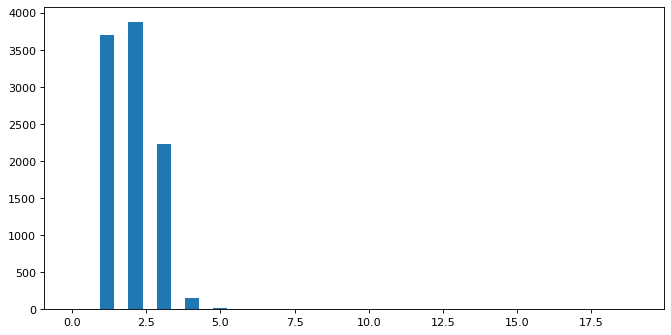

In [27]:
# Посмотрим на графике распределение значений
#hist_value_counts(train_df,'Rooms', 9)
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['Rooms'], bins = 40)
plt.show()

По графику видно, что практически все значения располагаются в интервале от 0 до 5. Остальных крайне мало. 

In [28]:
# Те значения, где кол-во комнат указано 0, примем за 1
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

# Все остальные выборосы - где кол-во комнат больше 6, заменим на 6
rooms_median = train_df['Rooms'].median()
print("rooms_median: ", rooms_median)
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = 6

rooms_median:  2.0


In [29]:
train_df['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       4
Name: Rooms, dtype: int64

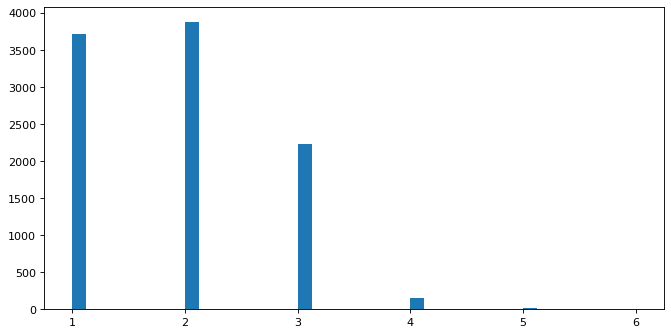

In [30]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['Rooms'], bins = 40)
plt.show()

#### Square - площадь квартиры

In [31]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

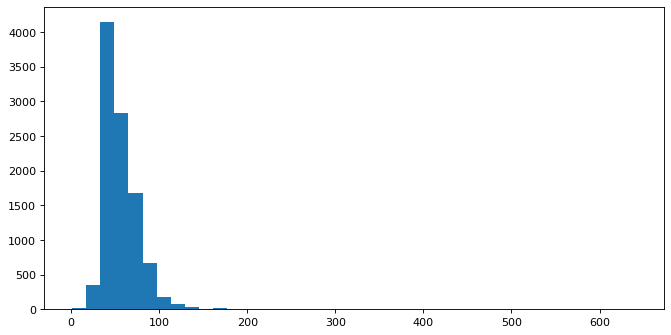

In [32]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['Square'], bins = 40)
plt.show()

In [33]:
square_quantile_99 = train_df['Square'].quantile(0.99)
square_quantile_99

117.85611482113002

In [34]:
# Все значения, которые выходят за квантиль, заменим на значение этого квантиля
# ! Идея - заменить на среднее значение между квантилем и этим значением
condition = train_df['Square'] > square_quantile_99        
#train_df.loc[condition, 'Square'] = (square_quantile_99 + train_df.loc[condition, 'Square'])/2
train_df.loc[condition, 'Square'] = square_quantile_99

In [35]:
train_df['Square'].sort_values().head(40)

7470     1.136859
4496     1.988943
9869     2.377248
8572     2.596351
161      2.954309
8805     4.380726
328      4.390331
4800     4.502784
5009     4.633498
9067     4.823679
1401     5.129222
7033     5.497061
9286    13.784865
5870    16.117154
3686    16.547242
9349    17.046188
8501    17.414181
6632    17.498542
8330    18.509177
9990    18.983962
7209    19.927423
890     20.213128
6379    20.606762
299     20.924926
9631    21.121279
623     22.072457
2576    22.682706
1717    22.691542
242     23.015919
5596    23.583220
4268    23.891837
3750    24.711701
1248    24.749737
7967    24.769705
964     25.410513
3656    25.449554
7237    25.494402
1208    25.543282
8854    25.761151
4028    25.903220
Name: Square, dtype: float64

In [36]:
train_df.loc[train_df['Square'] < 25, 'Square'] = 25

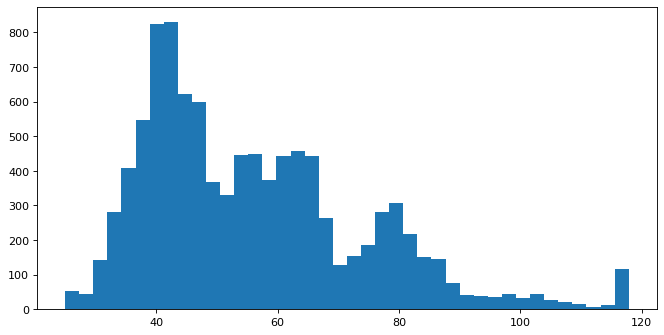

In [37]:
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['Square'], bins = 40)
plt.show()

#### KitchenSquare - площадь кухни

In [38]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [39]:
train_df['KitchenSquare']

0       10.0
1        8.0
2       10.0
3        1.0
4        9.0
        ... 
9995     6.0
9996     9.0
9997     5.0
9998     5.0
9999     6.0
Name: KitchenSquare, Length: 10000, dtype: float64

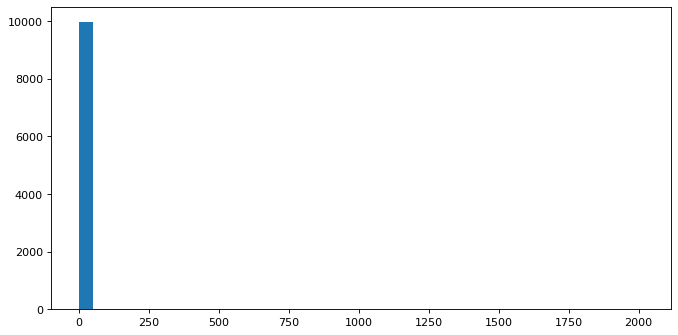

In [40]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['KitchenSquare'], bins = 40)
plt.show()

In [41]:
# Те значения, где площадь кухни 1970 и 2014 - явные выбросы, заменим их на медиану
kitchen_square_median = train_df['KitchenSquare'].median()
print("kitchen_square_median: ", kitchen_square_median)
train_df.loc[train_df['KitchenSquare'] == 1970, 'KitchenSquare'] = kitchen_square_median
train_df.loc[train_df['KitchenSquare'] == 2014, 'KitchenSquare'] = kitchen_square_median

kitchen_square_median:  6.0


In [42]:
# Площадь кухни меньше 2 метров - не похоже на правду
train_df.loc[train_df['KitchenSquare'] < 2, 'KitchenSquare']

3       1.0
8       1.0
9       1.0
18      1.0
19      1.0
       ... 
9981    1.0
9982    1.0
9983    1.0
9991    0.0
9993    0.0
Name: KitchenSquare, Length: 3157, dtype: float64

In [43]:
# Поэтому заменим все площади меньше 2 метров на 2
train_df.loc[train_df['KitchenSquare'] < 2, 'KitchenSquare'] = 2

In [44]:
# Посмотрим, каким значением ограничены 99% всех значений датасета
quantile_99 = train_df['KitchenSquare'].quantile(.990)
quantile_99

16.0

In [45]:
# Все значения, которые выходят за квантиль, заменим на значение этого квантиля
condition = train_df['KitchenSquare'] > quantile_99        
train_df.loc[condition, 'KitchenSquare'] = quantile_99

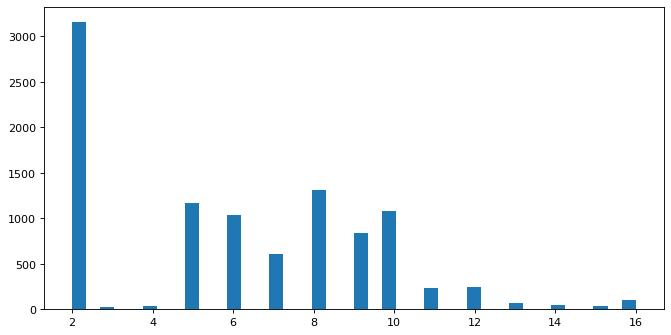

In [46]:
# Посмотрим на графике распределение значений после преобразований 
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['KitchenSquare'], bins = 40)
plt.show()

#### HouseFloor - этажность дома

In [47]:
train_df['HouseFloor'].isna().sum()

0

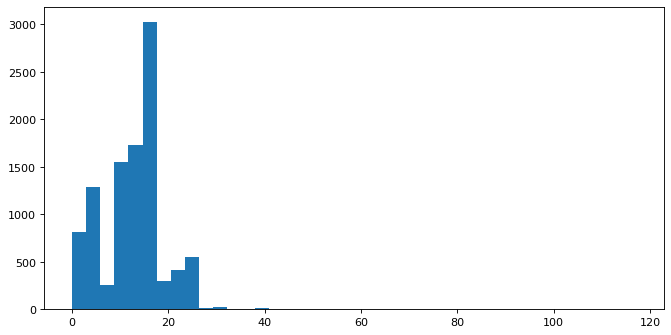

In [48]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['HouseFloor'], bins = 40)
plt.show()

In [49]:
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
39.0        2
48.0        2
47.0        1
38.0        1
36.0        1
29.0        1
44.0        1
31.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

In [50]:
# Допустим, сделали опечатку при записи 117 и 99 этажей.
train_df.loc[train_df['HouseFloor'] == 117, 'HouseFloor'] = 17
train_df.loc[train_df['HouseFloor'] == 99, 'HouseFloor'] = 9

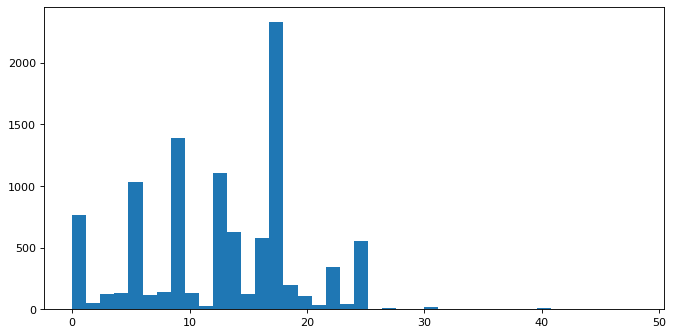

In [51]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['HouseFloor'], bins = 40)
plt.show()

In [52]:
train_df['HouseFloor'].mode()

0    17.0
Name: HouseFloor, dtype: float64

In [53]:
# все нулевые заменим на моду
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()

#### Floor - этаж, на котором находится квартира

In [54]:
# Посмотрим, какие есть возможные варианты этажности дома
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44., 45.,
       47., 48., nan])

In [55]:
# Посмотрим, какие значения этажей присутствуют в датасете
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

Проверим, есть ли такие значения Floor, которые превышают этажность дома. Это точно выбросы

In [56]:
condition_floor = train_df['Floor'] > train_df['HouseFloor']
print((condition_floor).sum())
# Выявлено 1825 ошибочных строк
# Добавим новое поле, которое разделит на выбросы и правильные значения
train_df['HouseFloor_outlier'] = 0
# 0й - тоже выброс, т.к. нумерация этажей начинается с 1
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
# Все записи, где этаж квартиры превышает этажность дома - это выбросы
train_df.loc[condition_floor, 'HouseFloor_outlier'] = 1

1556


In [57]:
# найдем индексы всех остальных
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
print(floor_outliers)
# И заменим на значение, не превыщающее этажность дома
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9912, 9913, 9921, 9930, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1556)


In [58]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear - год постройки дома

In [59]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [60]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1910           1
1916           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [61]:
# Явные выбросы
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

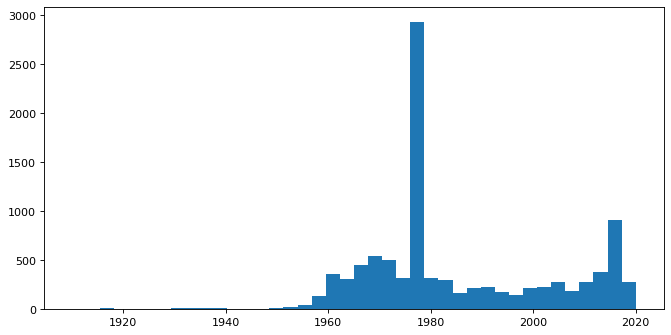

In [62]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['HouseYear'], bins = 40)
plt.show()

In [63]:
(train_df['HouseYear'] < 1950).sum()

77

In [64]:
# Значения слева
train_df.loc[train_df['HouseYear'] < 1950, 'HouseYear'] = 1950

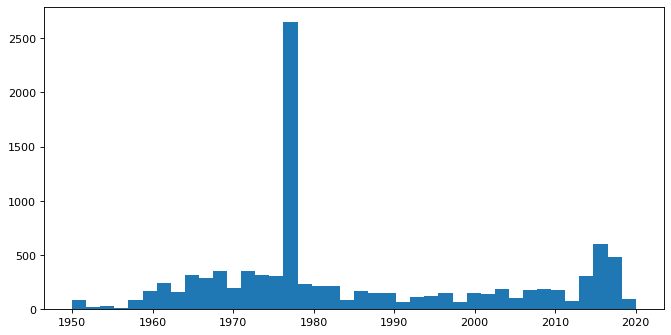

In [65]:
# Посмотрим на графике распределение значений
plt.figure(figsize=(10, 5), dpi=80)
plt.hist(train_df['HouseYear'], bins = 40)
plt.show()

In [66]:
#train_df.drop(['HouseFloor_outlier'], axis=1, inplace=True)
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseFloor_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.00000,10000.000000,9731.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.889200,56.004742,37.199645,6.09580,7.466900,12.929195,1985.005800,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.155600
std,4859.01902,43.587592,0.815592,18.084828,86.241209,3.42032,5.091768,6.327384,18.058604,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.362494
min,0.00000,0.000000,1.000000,25.000000,0.370619,2.00000,1.000000,1.000000,1950.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,2.00000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.00000,6.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.00000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000
max,16798.00000,209.000000,6.000000,117.856115,7480.592129,16.00000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


### Замена NaN значений

In [67]:
# Выведем количество пропущенных значений в каждом столбце
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor             269
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
HouseFloor_outlier       0
dtype: int64

#### Healthcare_1

Предскажем пропущенные значения по известным данным. 
1. Выберем часть признаков, полностью заполненных. А признак Healthcare_1 обозначим как целевую переменную. 
2. Разобьем выборку на 2 части: 
   * тренировочную - все данные, где Healthcare_1 заполнено, 
   * тестовую - все данные с Healthcare_1=NaN. 
3. Создадим модель, обучим ее на полных данных. И предскажем Healthcare_1 для тестовых данных.

#### LifeSquare

Что нужно сделать:
1. Предсказать пропущенные значения по известным данным
2. Проверить значения на адекватность по сравнению со всей площадью квартиры Square

Предскажем пропущенные значения по известным данным. 
1. Выберем часть признаков, полностью заполненных. А признак LifeSquare обозначим как целевую переменную. 
2. Разобьем выборку на 2 части: 
   * тренировочную - все данные, где LifeSquare заполнено, 
   * тестовую - все данные с LifeSquare=NaN. 
3. Создадим модель, обучим ее на полных данных. И предскажем LifeSquare для тестовых данных.

In [93]:
from sklearn.metrics import r2_score

class DataPreProcessor:
    """Подготовка исходных данных"""
    
    def __init__(self):
        self.rooms_median = None
        self.square_quantile_99 = None
        self.kitchen_square_median = None
        self.kitchen_square_quantile_99 = None
        self.house_floor_mode = None
        self.medians = None
        
    def fit(self, df):
        self.rooms_median = df['Rooms'].median()
        #print("self.rooms_median", self.rooms_median)
        self.square_quantile_99 = df['Square'].quantile(0.99)
        #print("self.square_quantile_99", self.square_quantile_99)
        self.kitchen_square_median = df['KitchenSquare'].median()
        #print("self.kitchen_square_median", self.kitchen_square_median)
        self.kitchen_square_quantile_99 = df['KitchenSquare'].quantile(.990)
        #print("self.rooms_median", self.kitchen_square_quantile_99)
        self.house_floor_median =  df['HouseFloor'].median()
        #print("self.house_floor_median", self.house_floor_median)
        self.medians = df.median()
        
    def transform(self, df, y_target=None):            
        df = self.outlier_Rooms(df)
        df = self.outlier_Square(df)
        df = self.outlier_KitchenSquare(df)
        df = self.outlier_HouseFloor(df)
        df = self.outlier_Floor(df)        
        df = self.outlier_HouseYear(df)                
        df = self.predict_HealthCare_1(df, y_target)
        df = self.fillna_LifeSquare(df)
        #df = self.predict_LifeSquare(df, y_target)
        return df
       
    def outlier_Rooms(self, df):
        # Те значения, где кол-во комнат указано 0, примем за 1
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        # Все остальные выборосы - где кол-во комнат больше 6, заменим на медиану       
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians.Rooms        
        df['Rooms'].fillna(self.medians.Rooms, inplace=True)
        return df
    
    def outlier_Square(self, df):        
        # Все значения, которые выходят за квантиль, заменим на значение этого квантиля        
        condition = df['Square'] > self.square_quantile_99         
        df.loc[condition, 'Square'] = self.square_quantile_99        
        # !Идея - заменить на среднее значение между квантилем и этим значением
        #df.loc[condition, 'Square'] = (self.square_quantile_99 + df.loc[condition, 'Square'])/2        
        # Все площади, что меньше 25 (их мало) меняем на 25
        df.loc[df['Square'] < 25, 'Square'] = 25              
        return df
    
    def outlier_KitchenSquare(self, df):
        # Те значения, где площадь кухни 1970 и 2014 - явные выбросы, заменим их на медиану        
        df.loc[df['KitchenSquare'] == 1970, 'KitchenSquare'] = self.kitchen_square_median
        df.loc[df['KitchenSquare'] == 2014, 'KitchenSquare'] = self.kitchen_square_median        
        # Значения 0, 1 - нереальные, кухня не может быть 0 или 1 м, поэтому все такие кухни пусть будут 2м        
        df.loc[df['KitchenSquare'] < 2, 'KitchenSquare'] = 2        
        # Все большие значения (их мало) - тоже выбросы, заменим их на 99й квантиль        
        condition = df['KitchenSquare'] > self.kitchen_square_quantile_99        
        df.loc[condition, 'KitchenSquare'] = self.kitchen_square_quantile_99
        return df
    
    def outlier_HouseFloor(self, df):        
        # Допустим, сделали опечатку при записи 117 и 99 этажей.
        df.loc[train_df['HouseFloor'] == 117, 'HouseFloor'] = 17        
        df.loc[train_df['HouseFloor'] == 99, 'HouseFloor'] = 9        
        # все нулевые заменим на медиану       
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.house_floor_median
        return df
    
    def outlier_Floor(self, df):
        # найдем индексы тех строк, где этаж квартиры превышает этажность дома
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        # И заменим на значение, не превыщающее этажность дома
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        return df
    
    def outlier_HouseYear(self, df):
        # Явные выбросы
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
        # Все постройки ранее 1950 года обозначим как 1950
        df.loc[df['HouseYear'] < 1950, 'HouseYear'] = 1950
        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2022
        return df
        
    # Предсказывает пропущенные значения для переменной HealthCare_1
    def predict_HealthCare_1(self, df, y_target=None):        
        # Часть столбцов возьмем для предсказания, а часть сохраним отдельно, чтобы потом их присоединить обратно
        columns_dropped = ['Id', 'DistrictId', 'LifeSquare', 'Ecology_2', 'Ecology_3', 'Shops_2']
        df_dropped = df[columns_dropped]
        columns_predict_Healthcare_1 = ['Id', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                                        'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']
        if y_target is not None:
            df["Price"] = y_target
            columns_predict_Healthcare_1 =  columns_predict_Healthcare_1 + ["Price"]
        
        # Выборка с заполненными значениями Healthcare_1. На ней будем строить модель и обучаться
        train_df_Healthcare_1 = df.loc[df['Healthcare_1'].notna(), columns_predict_Healthcare_1 + ['Healthcare_1']]
       
        # Выборка с пустыми значениями Healthcare_1. Для нее будем предсказывать Healthcare_1
        test_df_Healthcare_1 = df.loc[df['Healthcare_1'].isna(), columns_predict_Healthcare_1 + ['Healthcare_1']]
       
        # Сохраним столбец Id для тренировочной выборки, чтобы потом его вернуть обратно в том же виде
        train_df_Healthcare_1_Id = train_df_Healthcare_1['Id']
        # В качестве тренировочной выборки оставим все поля, кроме целевого и поля 'Id'
        X_hc = train_df_Healthcare_1.drop(columns=['Id', 'Healthcare_1'])        
        # В качестве целевых значений - наше поле 'Healthcare_1'
        y_hc = train_df_Healthcare_1['Healthcare_1']

        # Здесь собственно обучение модели и предсказание на валидационном датасете
        # Разобьем датасет с известными значениями Healthcare_1 на тренировочную и валидационную выборку
        # Валидационная выборка нужна, чтобы убедиться, что модель работает хорошо
        # и в случае необходимости подобрать оптимальные параметры        
        X_train_hc, X_valid_hc, y_train_hc, y_valid_hc = train_test_split(X_hc, y_hc, test_size=0.25, shuffle=True, random_state=21)
                  
        rf_model = RandomForestRegressor(random_state=21, criterion='mse')
        rf_model.fit(X_train_hc, y_train_hc)
        
        # предскажем значения целевой переменной для тренировочных данных
        y_train_preds = rf_model.predict(X_train_hc)
        # и конечно для валидационных данных
        y_valid_preds = rf_model.predict(X_valid_hc)
        
        # Посчитаем метрики r2_score для тренировочных и валидационных данных 
        r2_train = round(r2_score(y_train_hc, y_train_preds), 3)
        r2_valid = round(r2_score(y_valid_hc, y_valid_preds), 3)        
        #print("R2 train: ", r2_train)
        #print("R2 valid: ", r2_valid)
        
        # ! Обучим модель на всех данных
        rf_model.fit(X_hc, y_hc)
        y_train_preds_all = rf_model.predict(X_hc)
        r2_all = round(r2_score(y_hc,  y_train_preds_all), 3)
        #print("R2_all: ", r2_all)
        
        # ! Вот здесь суть - модель предсказывает недостающие значения поля Healthcare_1
        # Сохраним столбец Id для тестовой выборки, чтобы потом его вернуть обратно в том же виде
        test_df_Healthcare_1_Id = test_df_Healthcare_1['Id']
        test_df_Healthcare_1 = test_df_Healthcare_1.drop(columns=['Id', 'Healthcare_1'])
        # Предсказание Healthcare_1
        test_df_Healthcare_1['Healthcare_1'] = rf_model.predict(test_df_Healthcare_1)

        # После того, как пустые значения Healthcare_1 предсказаны, можно обратно соединять датасеты
        # Сначала вернем обратно поля Id в каждую выборку
        train_df_Healthcare_1['Id'] = train_df_Healthcare_1_Id        
        test_df_Healthcare_1['Id'] = test_df_Healthcare_1_Id
        # !!! Чтобы столбцы были одинаково расположены, чтобы данные не съехали при соединении
        test_df_Healthcare_1 = test_df_Healthcare_1[train_df_Healthcare_1.columns]
       
        # Соединим по вертикали тренировочную и тестовую выборки       
        df = pd.concat([train_df_Healthcare_1, test_df_Healthcare_1], axis=0)
        
        #!!!!!!!!!!!!!!!!!!!!!!! Надо вернуть, чтобы было в том же порядке, как и изначально
        # В df_dropped - изначальный порядок по Id, поэтому при соединении должен получиться порядок как в df_dropped
        # Также обратно присоединим остальные столбцы, которые не использовали для предсказания Healthcare_1       
        df = df.merge(df_dropped, left_on='Id', right_on='Id', how='right')
        if y_target is not None:
            if 'Price' in df.columns:
                df = df.drop(columns=['Price'])    
                
        # В итоге получаем точно такое же датасет, как на входе, только с заполненными значениями в поле Healthcare_1
        return df
       
    # Заполняет пропущенные значения для переменной LifeSquare - разность общей площади и площади кухни 
    def fillna_LifeSquare(self, df):     
        #print("LifeSquare NaN:", df['LifeSquare'].isna().sum())
        # Там где пустые значения, заполняем разностью площадей 
        df['LifeSquare'].fillna(df['Square'] - df['KitchenSquare'], inplace=True)  
        
        # Жилая площадь не может быть больше общей площади,
        # Поэтому слишком большие значения жилой площади также заменим на разность
        condition1 = df['LifeSquare'] > df['Square']
        df.loc[condition1, 'LifeSquare'] = df.loc[condition1, 'Square'] - df.loc[condition1, 'KitchenSquare']        
        
        #print("LifeSquare NaN:", df['LifeSquare'].isna().sum())        
        return df  
    
    # Предсказывает пропущенные значения для переменной LifeSquare
    def predict_LifeSquare(self, df, y_target=None):        
        # Часть столбцов возьмем для предсказания, а часть сохраним отдельно, чтобы потом их присоединить обратно
        columns_dropped = ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']
        df_dropped = df[columns_dropped]
        columns_predict = ['Id', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                           'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']
        #if y_target is not None:
        #    df["Price"] = y_target
        #    columns_predict =  columns_predict + ["Price"]
        
        # Выборка с заполненными значениями LifeSquare. На ней будем строить модель и обучаться
        train_df_LifeSquare = df.loc[df['LifeSquare'].notna(), columns_predict + ['LifeSquare']]
       
        # Выборка с пустыми значениями LifeSquare. Для нее будем предсказывать LifeSquare
        test_df_LifeSquare = df.loc[df['LifeSquare'].isna(), columns_predict + ['LifeSquare']]
       
        # Сохраним столбец Id для тренировочной выборки, чтобы потом его вернуть обратно в том же виде
        train_df_LifeSquare_Id = train_df_LifeSquare['Id']
        # В качестве тренировочной выборки оставим все поля, кроме целевого и поля 'Id'
        X_ls = train_df_LifeSquare.drop(columns=['Id', 'LifeSquare'])        
        # В качестве целевых значений - наше поле 'Healthcare_1'
        y_ls = train_df_LifeSquare['LifeSquare']

        # Здесь собственно обучение модели и предсказание на валидационном датасете
        # Разобьем датасет с известными значениями Healthcare_1 на тренировочную и валидационную выборку
        # Валидационная выборка нужна, чтобы убедиться, что модель работает хорошо
        # и в случае необходимости подобрать оптимальные параметры        
        X_train_ls, X_valid_ls, y_train_ls, y_valid_ls = train_test_split(X_ls, y_ls, test_size=0.25, shuffle=True, random_state=21)
                  
        rf_model = RandomForestRegressor(random_state=21, criterion='mse')
        rf_model.fit(X_train_ls, y_train_ls)
        
        # предскажем значения целевой переменной для тренировочных данных
        y_train_preds = rf_model.predict(X_train_ls)
        # и конечно для валидационных данных
        y_valid_preds = rf_model.predict(X_valid_ls)
        
        # Посчитаем метрики r2_score для тренировочных и валидационных данных 
        r2_train = round(r2_score(y_train_ls, y_train_preds), 3)
        r2_valid = round(r2_score(y_valid_ls, y_valid_preds), 3)        
        #print("R2 train: ", r2_train)
        #print("R2 valid: ", r2_valid)
        
        # ! Обучим модель на всех данных
        rf_model.fit(X_ls, y_ls)
        y_train_preds_all = rf_model.predict(X_ls)
        r2_all = round(r2_score(y_ls,  y_train_preds_all), 3)
        #print("R2_all: ", r2_all)
        
        # ! Вот здесь суть - модель предсказывает недостающие значения поля LifeSquare
        # Сохраним столбец Id для тестовой выборки, чтобы потом его вернуть обратно в том же виде
        test_df_LifeSquare_Id = test_df_LifeSquare['Id']
        test_df_LifeSquare = test_df_LifeSquare.drop(columns=['Id', 'LifeSquare'])
        # Предсказание Healthcare_1
        test_df_LifeSquare['LifeSquare'] = rf_model.predict(test_df_LifeSquare)

        # После того, как пустые значения LifeSquare предсказаны, можно обратно соединять датасеты
        # Сначала вернем обратно поля Id в каждую выборку
        train_df_LifeSquare['Id'] = train_df_LifeSquare_Id        
        test_df_LifeSquare['Id'] = test_df_LifeSquare_Id
        # !!! Чтобы столбцы были одинаково расположены, чтобы данные не съехали при соединении
        test_df_LifeSquare = test_df_LifeSquare[train_df_LifeSquare.columns]
       
        # Соединим по вертикали тренировочную и тестовую выборки       
        df = pd.concat([train_df_LifeSquare, test_df_LifeSquare], axis=0)
        
        #!!!!!!!!!!!!!!!!!!!!!!! Надо вернуть, чтобы было в том же порядке, как и изначально
        # В df_dropped - изначальный порядок по Id, поэтому при соединении должен получиться порядок как в df_dropped
        # Также обратно присоединим остальные столбцы, которые не использовали для предсказания LifeSquare  
        df = df.merge(df_dropped, left_on='Id', right_on='Id', how='right')
        if y_target is not None:
            if 'Price' in df.columns:
                df = df.drop(columns=['Price'])    
        
        # Жилая площадь не может быть больше общей площади,
        # Поэтому слишком большие значения жилой площади также заменим на разность
        condition1 = df['LifeSquare'] > df['Square']
        df.loc[condition1, 'LifeSquare'] = df.loc[condition1, 'Square'] - df.loc[condition1, 'KitchenSquare']   
        
        # В итоге получаем точно такое же датасет, как на входе, только с заполненными значениями в поле Healthcare_1
        return df
   

## 2. Добавление новых фич

### Dummy-признаки

In [69]:
#binary_to_numbers = {'A': 0, 'B': 1}
#binary_to_numbers = {0: 'A', 1:'B' }
#train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
#train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
#train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [70]:
# Добавим dummy-признаки для категориальных переменных
train_df = pd.concat([train_df, pd.get_dummies(train_df[['Ecology_2', 'Ecology_3', 'Shops_2' ]])], axis=1) 
# Исходные признаки удалим
#train_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2' ], axis=1, inplace=True)
# Или по другому - отфильтровать ненужные столбцы
# код можно запускать несколько раз и не будет ошибки
train_df = train_df[train_df.columns[~train_df.columns.isin(['Ecology_2', 'Ecology_3', 'Shops_2'])]]

### Новые признаки DistrictSize, IsDistrictLarge

In [71]:
# Каждому району поставим в соответствие количество квартир в нем
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,199,1
201,117,1
202,207,1
203,209,1


In [72]:
# Добавим новый признак к нашему датасету
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Price,HouseFloor_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,305018.871089,0,0,1,0,1,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,177734.553407,0,0,1,0,1,0,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,1,0,1,0,1,652
3,2352,1,1.0,40.409907,NaN,2.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,0,1,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,343995.102962,0,0,1,0,1,0,1,89


In [73]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [74]:
# IsDistrictLarge - район обозначим как большой, если в нем больше 100 квартир
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [75]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,HouseFloor_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,0,1,0,1,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,1,0,1,0,1,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,1,0,1,0,1,652,1
3,2352,1,1.0,40.409907,NaN,2.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,0,1,0,1,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,1,0,1,0,1,89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,119367.455796,0,0,1,0,1,0,1,118,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,NaN,1977,0.072158,...,199715.148807,0,0,1,0,1,1,0,851,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,165953.912580,0,0,1,0,1,0,1,7,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,171842.411855,0,0,1,0,1,0,1,165,1


### MedianPriceByDistrict

Медиана цены квартиры для каждого района

In [76]:
# Сгруппируем по району, и по количеству комнат в квартире: район - однушка, двушка, трешка и т.д.
# И для каждой группы посчитаем медиану цены
# И переименуем результат аггрегации в MedianPriceByDistrict
median_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedianPriceByDistrict'})

median_price_by_district.isna().sum()

DistrictId               0
Rooms                    0
MedianPriceByDistrict    0
dtype: int64

In [77]:
# Добавим новый признак к нашему датасету
train_df = train_df.merge(median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize,IsDistrictLarge,MedianPriceByDistrict
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,0,1,0,1,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,1,0,1,0,1,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,1,0,1,0,1,652,1,244005.272380
3,2352,1,1.0,40.409907,NaN,2.0,10,22.0,1977,0.007122,...,0,0,1,0,1,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,1,0,1,0,1,89,0,201584.441255


In [78]:
# Добавление всех новых фич
class FeatureGenerator:
    """Добавление новых фич в датасет"""
    
    def __init__(self):
        self.median_price_by_district = None
        
    def fit(self, X, y):
        # Сгруппируем по району, и по количеству комнат в квартире: район - однушка, двушка, трешка и т.д.
        # И для каждой группы посчитаем медиану цены
        # И переименуем результат аггрегации в MedianPriceByDistrict
        df = X.copy()
        df['Price'] = y.values
        self.median_price_by_district =  df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedianPriceByDistrict'})        
        
    def transform(self, X):
        X = self.add_dummies(X)
        #X = self.add_DistrictSize(X)
        #X = self.add_MedianPriceByDistrict(X)
        return X
    
    def add_dummies(self, X):
        # Добавим dummy-признаки для категориальных переменных
        X = pd.concat([X, pd.get_dummies(X[['Ecology_2', 'Ecology_3', 'Shops_2' ]])], axis=1) 
        # Исходные признаки удалим
        #X.drop(['Ecology_2', 'Ecology_3', 'Shops_2' ], axis=1, inplace=True)
        # Или по другому - отфильтровать ненужные столбцы
        # код можно запускать несколько раз и не будет ошибки
        X = X[X.columns[~X.columns.isin(['Ecology_2', 'Ecology_3', 'Shops_2'])]]
        return X
    
    def add_DistrictSize(self, X):
        # Каждому району поставим в соответствие количество квартир в нем
        # district_size - получится новый датасет с полями DistrictId, DistrictSize
        district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Добавим новый признак к нашему датасету
        X = X.merge(district_size, on='DistrictId', how='left')
        # Также добавим признак IsDistrictLarge - район обозначим как большой, если в нем больше 100 квартир
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        return X
    
    def add_MedianPriceByDistrict(self, X):        
        # Добавим новый признак к нашему датасету
        X = X.merge(self.median_price_by_district, on=['DistrictId', 'Rooms'], how='left')        
        return X

## 3. Обучение. Выбор модели

#### Разбиение на train и test

In [94]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [95]:
target_name = 'Price'
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
9239,11585,23,1.0,43.380798,NaN,1.0,18,25.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
6930,2917,30,3.0,83.596365,NaN,1.0,3,16.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
8136,9635,47,2.0,53.610583,31.289235,8.0,14,12.0,1979,0.298205,B,B,16,4048,3,NaN,1,3,B
3424,8748,3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,B,B,37,5288,0,1937.0,3,2,B
6518,5704,62,1.0,53.810968,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [97]:
preprocessor = DataPreProcessor()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train, y_train)
X_valid = preprocessor.transform(X_valid, y_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [98]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [99]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [100]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## 5. Предсказание на тестовых данных. Выгрузка предсказанных значений

Train R2:	0.959
Test R2:	0.73


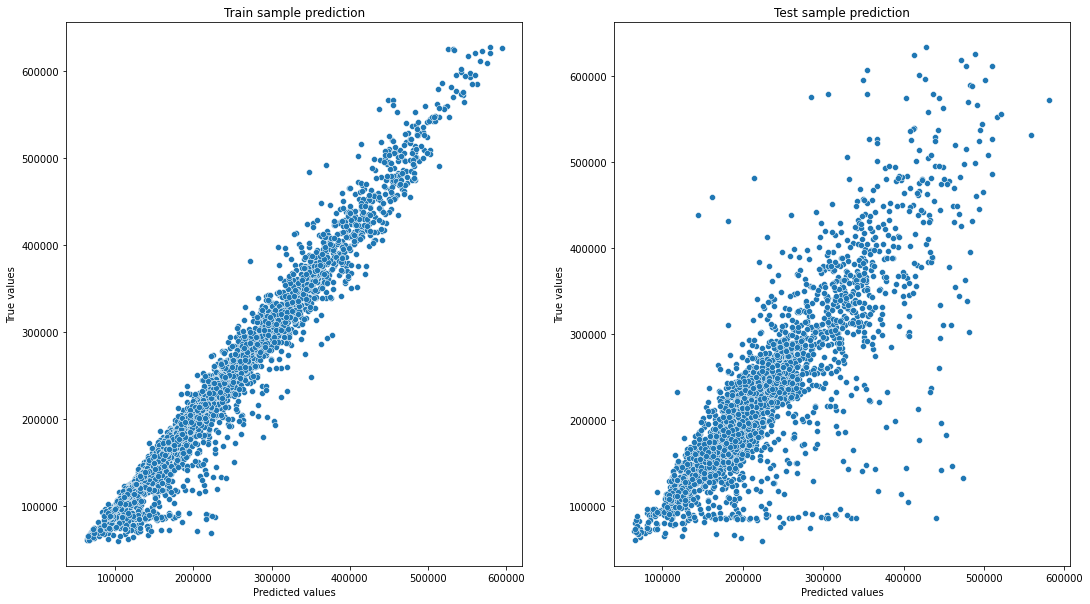

In [101]:
target_name = 'Price'

rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

Train R2:	0.963


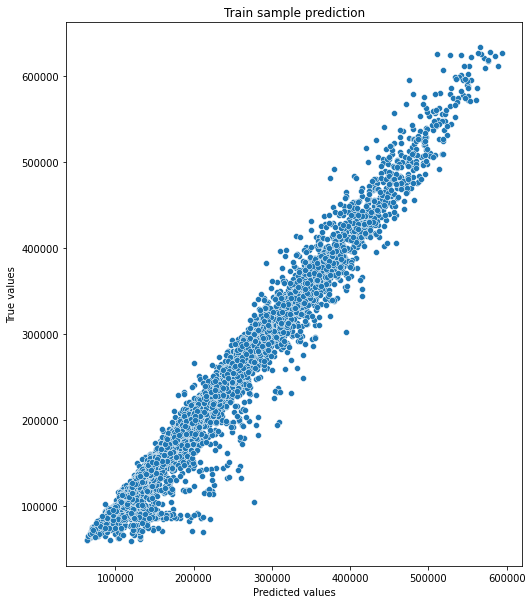

In [102]:
# Предсказание на всех данных
preprocessor = DataPreProcessor()
preprocessor.fit(X)
X = preprocessor.transform(X, y)

features_gen = FeatureGenerator()
features_gen.fit(X, y)
X= features_gen.transform(X)

rf_model.fit(X, y)
y_preds = rf_model.predict(X)
print("Train R2:\t" + str(round(r2(y, y_preds), 3)))

plt.figure(figsize=(18,10))

plt.subplot(121)
sns.scatterplot(x=y_preds, y=y)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Train sample prediction')

plt.show()

### Предсказание на тестовых данных

In [103]:
test_df

,Id,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Shops_1,Healthcare_1,DistrictId,LifeSquare,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,4567,1.0,36.847630,5.0,5,9.0,1970,0.036122,24,4378,...,1,1036.00,44,19.094182,0,1,0,1,0,1
1,5925,1.0,42.493907,10.0,7,17.0,2017,0.072158,2,629,...,0,396.31,62,32.493907,0,1,0,1,1,0
2,960,2.0,59.463678,9.0,19,19.0,1977,0.211401,9,1892,...,1,648.82,27,50.463678,0,1,0,1,0,1
3,3848,3.0,49.646030,6.0,2,2.0,1965,0.014073,2,475,...,0,208.31,23,33.893825,0,1,0,1,0,1
4,746,1.0,53.837056,2.0,8,17.0,1977,0.309479,35,7715,...,6,990.00,74,51.837056,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,2.0,43.177521,5.0,3,5.0,1962,0.069660,31,6119,...,2,712.45,29,30.339945,0,1,0,1,0,1
4996,16138,3.0,93.698122,10.0,21,27.0,2018,0.060753,15,2787,...,7,520.00,38,83.698122,0,1,0,1,0,1
4997,3912,1.0,33.656723,5.0,2,5.0,1966,0.038693,28,6533,...,5,1015.00,101,19.003259,0,1,0,1,0,1
4998,5722,1.0,38.635155,9.0,8,14.0,1970,0.089040,33,7976,...,11,876.17,10,20.976257,0,1,0,1,0,1


In [104]:
y_test = rf_model.predict(test_df)
y_test

array([158209.17152308, 121315.36977594, 152961.65515748, ...,
       147117.44410718, 192184.73789972, 244072.9010722 ])

In [105]:
submit = pd.read_csv('sample_submission.csv')

In [106]:
submit['Price'] = y_test
submit

,Id,Price
0,4567,158209.171523
1,5925,121315.369776
2,960,152961.655157
3,3848,134371.122752
4,746,214881.545323
...,...,...
4995,10379,171649.820967
4996,16138,359311.003907
4997,3912,147117.444107
4998,5722,192184.737900


In [107]:
submit.to_csv('rf_submit.csv', index=False)

### Результат на Kaggle

Olga Sautina

0.73260